<a href="https://colab.research.google.com/github/Morfinic/PWR_1_st.2_UM/blob/master/P2_Face_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Imports
---

In [58]:
import uuid
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from datetime import datetime
from PIL import Image as pimg

---
# Funkcja do robienia zdjęć kamerą
---

In [59]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  !mkdir /content/faceImg
  with open("faceImg/" + filename, 'wb') as f:
    f.write(binary)
  return filename

---
# Import datasetu z kaggle
---

In [60]:
from google.colab import files
%cd /content
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d "shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset"
import zipfile
zip_ref = zipfile.ZipFile("detect-ai-generated-faces-high-quality-dataset.zip", 'r')
zip_ref.extractall('/content')
zip_ref.close()

/content


mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [61]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
# Przygotowanie datasetu
---

In [62]:
datasetPath = "/content/AI-face-detection-Dataset"

imgDim = (150, 150)
batchSize = 32

(trainingSet, validationSet) = tf.keras.utils.image_dataset_from_directory(
    datasetPath,
    validation_split=0.2,
    subset="both",
    seed=500,
    image_size=imgDim,
    batch_size=batchSize
)

valSetSize = len(validationSet)

validationSet = validationSet.take(max(valSetSize//2, 1))
testingSet = validationSet.take(valSetSize//2)

print("Testing set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Training classes: ", trainingSet.class_names)


Found 3203 files belonging to 2 classes.
Using 2563 files for training.
Using 640 files for validation.
Testing set lenght: 81
Validation set lenght: 10
Training classes:  ['AI', 'real']


---
# VGG16
---

In [64]:
from threading import active_count
VGG16_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(*imgDim, 3),
    pooling="max"
)

for layer in VGG16_base.layers:
    layer.trainable = False

input = tf.keras.Input(shape=(*imgDim, 3))
x = VGG16_base(input, training=False)
x = BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True
)(x)
x = Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(0.01),
    bias_regularizer=regularizers.l2(0.01),
    activity_regularizer=regularizers.l1(0.01)
)(x)
x = Dropout(
    rate = .4,
    seed = 500
)(x)
x = Dense(
    64,
    activation="relu"
)(x)
output = Dense(1, activation="sigmoid")(x)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

VGG16_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,864,577 (56.70 MB)

 Trainable params: 148,865 (581.50 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

---
# Trenowanie
---

In [65]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)

print("Starting trainging at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 200,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Finished trainging at", datetime.now())
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting trainging at 2025-04-13 18:09:30.564995
Epoch 1/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.7018 - loss: 32.6339 - precision_2: 0.7572 - recall_2: 0.7997 - val_accuracy: 0.8375 - val_loss: 25.5526 - val_precision_2: 0.8235 - val_recall_2: 0.9677
Epoch 2/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.7729 - loss: 13.2120 - precision_2: 0.7687 - recall_2: 0.9538 - val_accuracy: 0.6906 - val_loss: 6.2875 - val_precision_2: 0.6891 - val_recall_2: 0.9908
Epoch 3/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.7005 - loss: 4.3291 - precision_2: 0.6960 - recall_2: 0.9966 - val_accuracy: 0.6781 - val_loss: 3.8204 - val_precision_2: 0.6781 - val_recall_2: 1.0000
Epoch 4/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.6776 - loss: 3.1480 - precision_2: 0.6773 - recall_2: 1.0000 - val_accuracy: 0.6781 - val_loss: 3.2335 - val_precision_2: 0.6781 - val_recall_2: 1.0000
Epoch 5/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.6

---
# Sprawdzanie sieci
---

In [66]:
loadedModel = tf.keras.models.load_model("VGG16-1-gen.keras")

In [67]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6848 - loss: 0.6244 - precision_2: 0.6848 - recall_2: 1.0000
Loss: 0.6297
Accuracy: 0.6781
Precision: 0.6781
Recall: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


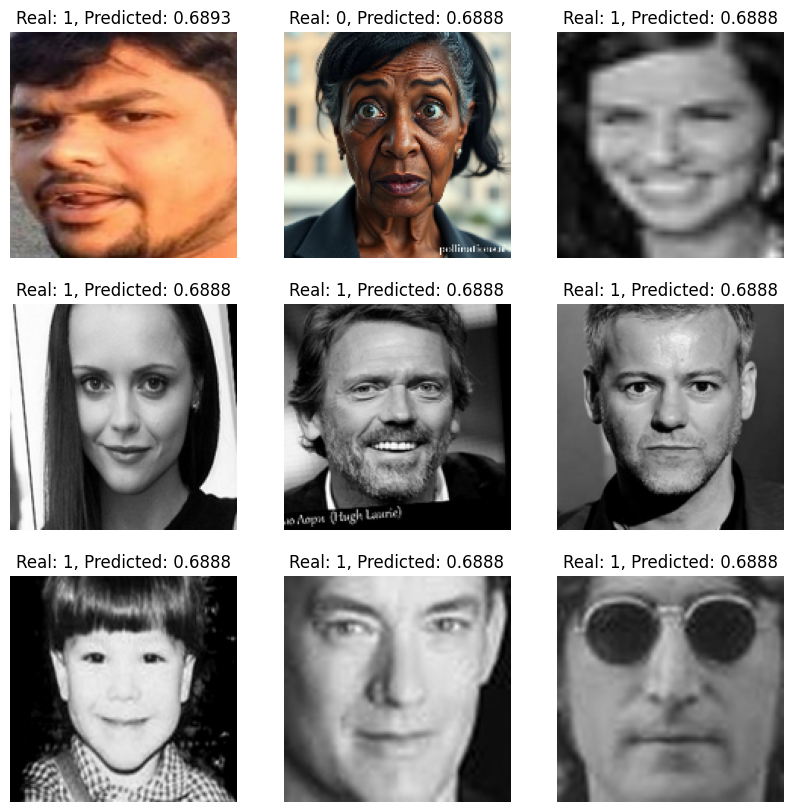

In [70]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")


<IPython.core.display.Javascript object>

mkdir: cannot create directory ‘/content/faceImg’: File exists
[Errno 2] No such file or directory: 'faceImg/2f38668e.jpg'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


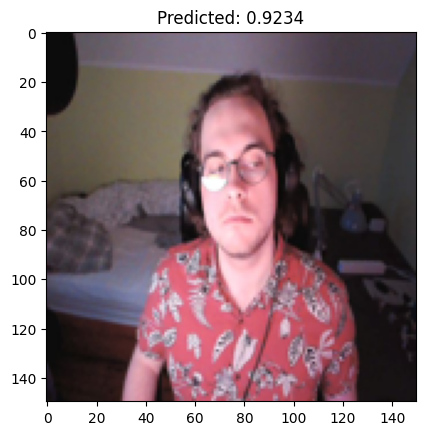

In [38]:
from IPython.display import Image
try:
  filename = take_photo(filename=str(uuid.uuid4())[:8]+".jpg")
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  %cd /content/faceImg
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

with pimg.open(filename) as img:
  res = img.resize(imgDim)
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()


Saving 20220819_174540.jpg to 20220819_174540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


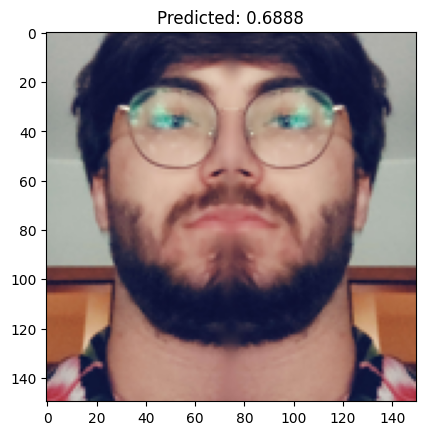

In [69]:
uploaded = files.upload()
uploadedName = list(uploaded.keys())[0]

with pimg.open(uploadedName) as img:
  res = img.resize(imgDim)
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()
